# To Do

1. Convert HVAC states categorical --> dummy variables.
2. Check to see if the TIMESTEPS are all consecutive data.
3. Try,
    1. stateful v/s stateless LSTMs.
    2. Recursive and Direct output multi-step forecasting.
    3. Training on one-month of data and predicting 4 hours ahead.
    4. ANN.
    5. Adding additional features - holidays & weather data.


# Note

1. For Augmented-Dickey-Fuller Test, null hypothesis is that the data is non-stationary. If p-value > critical value then the data is non-stationary.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_folder = 'data'
site = 'avenal-movie-theatre'

# Import data

## Eagle (power) data

In [3]:
df_raw = pd.read_csv(data_folder + '/power_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

,power
datetime,
2018-01-01 00:00:04.574889+00:00,400.0
2018-01-01 00:00:10.215095+00:00,440.0
2018-01-01 00:00:13.496753+00:00,440.0
2018-01-01 00:00:20.031088+00:00,440.0
2018-01-01 00:00:33.525473+00:00,400.0


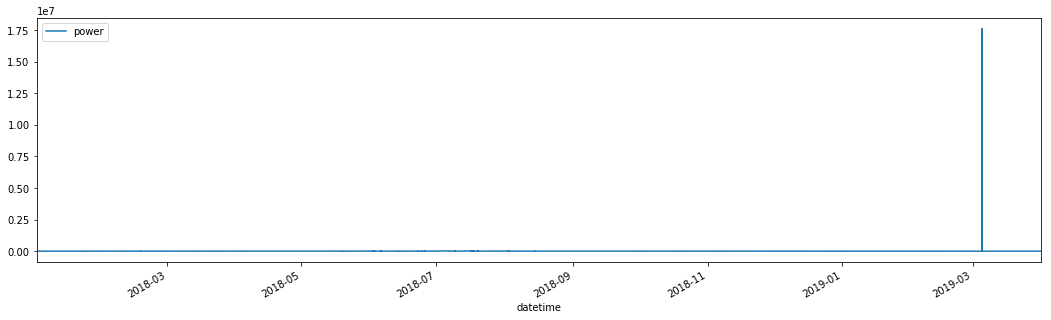

In [4]:
df_raw.plot(figsize=(18,5))

## Check for missing data

In [5]:
df_raw.isna().any()

power    False
dtype: bool

## Clean data

In [6]:
df_processed = df_raw.resample('15T').mean()
df_processed = df_processed[df_processed['power'] < 10000000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,416.991150
2018-01-01 00:15:00+00:00,477.477477
2018-01-01 00:30:00+00:00,430.990991
2018-01-01 00:45:00+00:00,504.081633
2018-01-01 01:00:00+00:00,453.565217


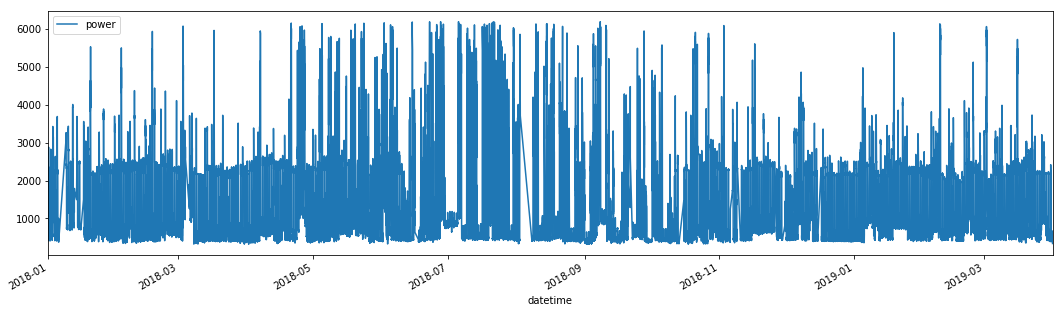

In [7]:
df_processed.plot(figsize=(18,5))

## Normalize data

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df_normalized = pd.DataFrame(scaler.fit_transform(df_processed), 
                             columns=df_processed.columns, index=df_processed.index)
df_normalized.head()

,power
datetime,
2018-01-01 00:00:00+00:00,0.016522
2018-01-01 00:15:00+00:00,0.026825
2018-01-01 00:30:00+00:00,0.018907
2018-01-01 00:45:00+00:00,0.031357
2018-01-01 01:00:00+00:00,0.022752


## Check for stationarity

In [9]:
result = adfuller(df_normalized['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistic            -30.665127
p-value                     0.000000
#Lags Used                 48.000000
#Observations Used      40294.000000
Critical Value (1%)        -3.430512
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566808
dtype: float64

## HVAC States data

In [10]:
df_raw_hvac_states = pd.read_csv(data_folder + '/hvac_states_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw_hvac_states.head()

,hvac_zone_lobby,hvac_zone_main_hallway,hvac_zone_room_a,hvac_zone_theater_2,hvac_zone_back_hallway,hvac_zone_room_d,hvac_zone_pegasus_hall,hvac_zone_theater_1
2018-01-01 00:00:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:05:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:10:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:20:00+00:00,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Check for missing data

In [11]:
df_raw_hvac_states.isna().any()

hvac_zone_lobby           True
hvac_zone_main_hallway    True
hvac_zone_room_a          True
hvac_zone_theater_2       True
hvac_zone_back_hallway    True
hvac_zone_room_d          True
hvac_zone_pegasus_hall    True
hvac_zone_theater_1       True
dtype: bool

## Clean data

In [12]:
def func(row):
    """ Possible situations: (0,0,0), (1,0,1), (0,1,2) --> 0, 1, 2
    
    If all are same --> first element
    If there is a majority among the 3 --> majority
    If all are unique --> last element
    
    """

    count = len(set(list(row.values)))
    if count == 1:
        return row.values[0]
    elif count == 2:
        return max(set(list(row.values)), key=list(row.values).count)
    else:
        return row.values[-1]
    
resample_df_hvac = df_raw_hvac_states.resample('15T').apply(func).dropna()

### TODO: Check if 'forward fill' is correct by determining the number of consecutive NaN's in all columns

In [13]:
# resample_df_hvac = resample_df_hvac.fillna(method='ffill')
# resample_df_hvac.isna().any()

## Concatenate data

In [14]:
df = pd.concat([df_normalized, resample_df_hvac], axis=1)
df.head()

,power,hvac_zone_lobby,hvac_zone_main_hallway,hvac_zone_room_a,hvac_zone_theater_2,hvac_zone_back_hallway,hvac_zone_room_d,hvac_zone_pegasus_hall,hvac_zone_theater_1
2018-01-01 00:00:00+00:00,0.016522,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00+00:00,0.026825,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2018-01-01 00:30:00+00:00,0.018907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:45:00+00:00,0.031357,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00+00:00,0.022752,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
missing = df['power'].isnull().sum()
total = df['power'].shape[0]
print('missing data for power: ', (missing/total)*100, '%')

missing data for power:  4.6602859506085315 %


In [16]:
df.dropna(inplace=True)

## Box plot

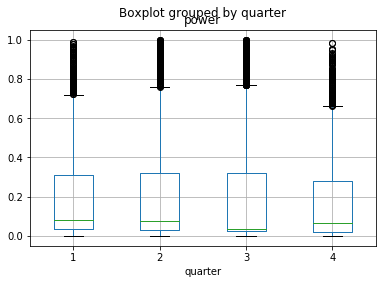

In [17]:
df_box_plot = pd.DataFrame(df['power'])
df_box_plot['quarter'] = df_box_plot.index.quarter
df_box_plot.boxplot(column='power', by='quarter')

## Histogram

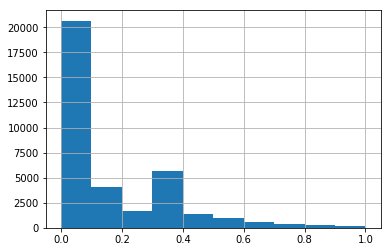

In [18]:
df['power'].hist()

## ACF and PACF

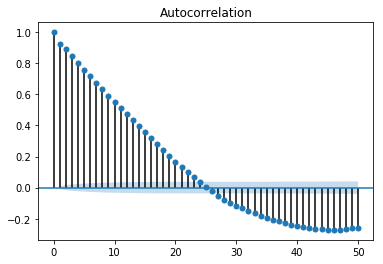

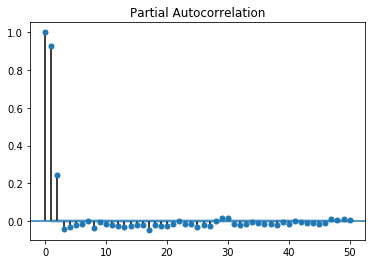

In [19]:
fig1 = plot_acf(df_processed['power'], lags=50)
fig2 = plot_pacf(df_processed['power'], lags=50)

# Prepare data

## Split into training & testing data

In [37]:
# X_train = df[(df.index < '2018-12-31')]
# y_train = df.loc[(df.index < '2018-12-31'), 'power']

# X_test = df[(df.index >= '2019-01-01')]
# y_test = df.loc[(df.index >= '2019-01-01'), 'power']

train_start_date = pd.Timestamp('2018-01-01')
train_end_date   = pd.Timestamp('2018-02-01')
test_start_date  = pd.Timestamp('2018-02-01')
test_end_date  = pd.Timestamp('2018-04-01')

X_train = df[train_start_date:train_end_date]
y_train = df.loc[train_start_date:train_end_date, 'power']

X_test  = df[test_start_date:test_end_date]
y_test  = df.loc[test_start_date:test_end_date, 'power']

## Prepare data for LSTM

In [39]:
# Number of columns in X_train
NUM_FEATURES    = len(X_train.columns)

# ACF plot shows significant autocorrelation till lag=24
NUM_TIMESTEPS   = 672

# 4 hour predictions = Sixteen 15min predictions 
NUM_PREDICTIONS = 16


train_x, train_y = [], []
for i in range(NUM_TIMESTEPS, len(X_train)-NUM_PREDICTIONS):
    train_x.append(X_train.values[i-NUM_TIMESTEPS:i])
    train_y.append(y_train.values[i:i+NUM_PREDICTIONS])
    
train_x, train_y = np.array(train_x), np.array(train_y)

print(train_x.shape)
print(train_y.shape)


test_x, test_y = [], []
for i in range(NUM_TIMESTEPS, len(X_test)-NUM_PREDICTIONS):
    test_x.append(X_test.values[i-NUM_TIMESTEPS:i])
    test_y.append(y_test.values[i:i+NUM_PREDICTIONS])
    
test_x, test_y = np.array(test_x), np.array(test_y)

print(test_x.shape)
print(test_y.shape)

(290, 672, 9)
(290, 16)
(4116, 672, 9)
(4116, 16)


# LSTM

In [40]:
model = Sequential([
    
    LSTM(units=128, input_shape=(NUM_TIMESTEPS, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
                
    LSTM(units=64, return_sequences=False),
    Dropout(0.2),

    Dense(NUM_PREDICTIONS)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 672, 128)          70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 672, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
Total params: 121,104
Trainable params: 121,104
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Default shuffle=True
history = model.fit(train_x, train_y,
                    epochs=10, batch_size=128, shuffle=False, callbacks=callbacks,
                    validation_data=(test_x, test_y))

Instructions for updating:
Use tf.cast instead.
Train on 290 samples, validate on 4116 samples
Epoch 1/10
290/290 [==============================] - 14s 49ms/step - loss: 0.0769 - acc: 0.0897 - val_loss: 0.0417 - val_acc: 0.0566
Epoch 2/10
290/290 [==============================] - 13s 45ms/step - loss: 0.0568 - acc: 0.0517 - val_loss: 0.0365 - val_acc: 0.0581
Epoch 3/10
290/290 [==============================] - 13s 46ms/step - loss: 0.0470 - acc: 0.0483 - val_loss: 0.0322 - val_acc: 0.0632
Epoch 4/10
290/290 [==============================] - 14s 47ms/step - loss: 0.0412 - acc: 0.0655 - val_loss: 0.0298 - val_acc: 0.0729
Epoch 5/10
290/290 [==============================] - 18s 61ms/step - loss: 0.0383 - acc: 0.0897 - val_loss: 0.0284 - val_acc: 0.0960
Epoch 6/10
290/290 [==============================] - 26s 89ms/step - loss: 0.0362 - acc: 0.1034 - val_loss: 0.0282 - val_acc: 0.0984
Epoch 7/10
290/290 [==============================] - 22s 77ms/step - loss: 0.0339 - acc: 0.0828 - va

# Results

## Loss

In [49]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [x for x in range(len(train_loss))]

df_train_loss = pd.DataFrame(train_loss, columns=['train_loss'], index=epochs)
df_val_loss   = pd.DataFrame(val_loss, columns=['val_loss'], index=epochs)

df_loss = pd.concat([df_train_loss, df_val_loss], axis=1)

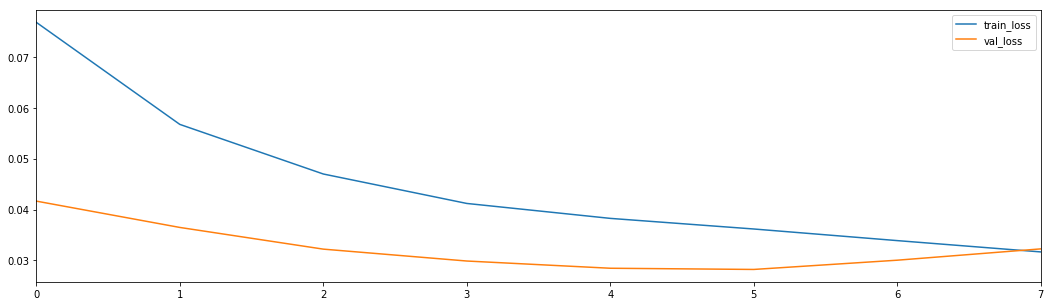

In [50]:
df_loss.plot(figsize=(18,5))

## Accuracy

In [51]:
train_acc = history.history['acc']
val_acc   = history.history['val_acc']
epochs    = [x for x in range(len(train_acc))]

df_train_acc = pd.DataFrame(train_acc, columns=['train_acc'], index=epochs)
df_val_acc   = pd.DataFrame(val_acc, columns=['val_acc'], index=epochs)

df_acc = pd.concat([df_train_acc, df_val_acc], axis=1)

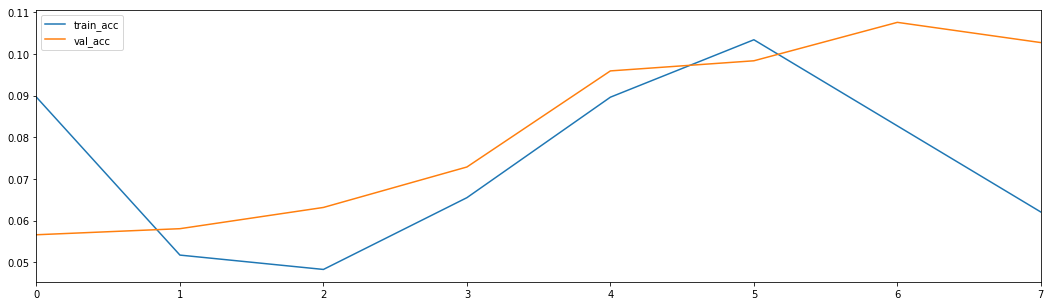

In [52]:
df_acc.plot(figsize=(18,5))

# Predictions

In [53]:
pred_y = model.predict(test_x)

In [54]:
df_y_pred = pd.DataFrame(scaler.inverse_transform(pred_y),
                         index=y_test[NUM_TIMESTEPS:-NUM_PREDICTIONS].index)

df_y_true = pd.DataFrame(scaler.inverse_transform(test_y),
                         index=y_test[NUM_TIMESTEPS:-NUM_PREDICTIONS].index)

In [58]:
timestamp = pd.Timestamp('2018-02-14 22:15:00+00:00')

predictions  = df_y_pred.loc[timestamp, :]
ground_truth = df_y_true.loc[timestamp, :]

df_plot = pd.concat([predictions, ground_truth], axis=1)
df_plot.columns = ['pred', 'true']

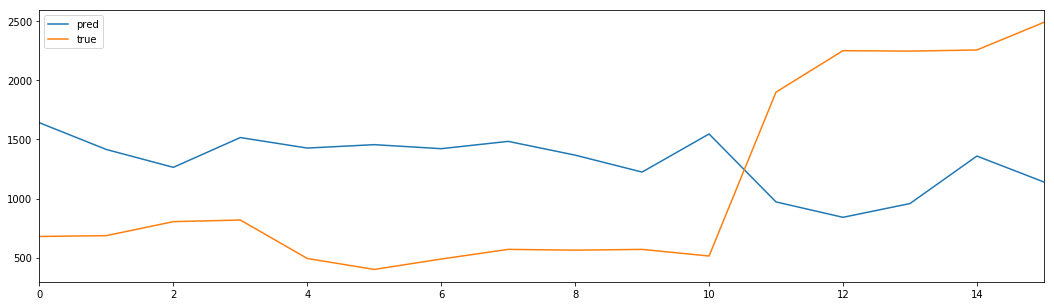

In [59]:
df_plot.plot(figsize=(18,5))